# Data Analysis
----------------------

## Library Importation

In [1]:
import sys
sys.path.append("./lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lib.Methods import GeneralMethods
from lib.edasSearch import EdasHyperparameterSearch
from lib.Hiperparametros import HyperparameterSwitcher
from lib.ImportacionModelos import getClassifierNames
from lib.ImportacionModelos import getClassifierModels
from lib.ImportacionModelos import getRegressorNames
from lib.ImportacionModelos import getRegressorModels
from lib.graphicGenerator import GraphicBuilder

dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
description = pd.read_csv("data/description.csv", sep=";")
dfTest = pd.read_csv("data/UJIndoorLoc_validationData.csv")
gbTrain = GraphicBuilder(dfTrain)
gbTest = GraphicBuilder(dfTest)

## Data Description

In [2]:
description = pd.read_csv("data/description.csv", sep=";")
display(description)

,Attribute,Definition
WAP001,Intensity value for WAP001,Negative integer values from -104 to 0 and +1...
...,...,...
WAP520,Intensity value for WAP520,Negative integer values from -104 to 0 and +1...
Longitude,Longitude,Negative real values from -7695.9387549299299...
Latitude,Latitude,Positive real values from 4864745.7450159714 ...
Floor,Altitude in floors inside the building,Integer values from 0 to 4.
BuildingID,ID to identify the building. Measures were ta...,Categorical integer values from 0 to 2.
SpaceID,Internal ID number to identify the Space (off...,Categorical integer values.
RelativePosition,Relative position with respect to the Space (...,Categorical integer values.
UserID,User identifier,Categorical integer values.


In [3]:
dfTrain.FLOOR = dfTrain.FLOOR.apply(str)
dfTrain.BUILDINGID = dfTrain.BUILDINGID.apply(str)
dfTrain.SPACEID = dfTrain.SPACEID.apply(str)
dfTrain.RELATIVEPOSITION = dfTrain.RELATIVEPOSITION.apply(str)
dfTrain.USERID = dfTrain.USERID.apply(str)
dfTrain.PHONEID = dfTrain.PHONEID.apply(str)
# Colums Data Description
display(dfTrain[dfTrain.columns.values[519:]].describe(include=['int64', 'float']))
display(dfTrain[dfTrain.columns.values[519:]].describe(include=['object']))
# Building vs Floor Distribution of Data
display(pd.crosstab(dfTrain.FLOOR, dfTrain.BUILDINGID))

,WAP520,LONGITUDE,LATITUDE,TIMESTAMP
count,19937.0,19937.000000,1.993700e+04,1.993700e+04
mean,100.0,-7464.275947,4.864871e+06,1.371421e+09
std,0.0,123.402010,6.693318e+01,5.572054e+05
min,100.0,-7691.338400,4.864746e+06,1.369909e+09
25%,100.0,-7594.737000,4.864821e+06,1.371056e+09
50%,100.0,-7423.060900,4.864852e+06,1.371716e+09
75%,100.0,-7359.193000,4.864930e+06,1.371721e+09
max,100.0,-7300.818990,4.865017e+06,1.371738e+09


,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,19937,19937,19937,19937,19937,19937
unique,5,3,123,2,18,16
top,3,2,202,2,11,14
freq,5048,9492,484,16608,4516,4835


BUILDINGID,0,1,2
FLOOR,,,
0,1059,1368,1942
1,1356,1484,2162
2,1443,1396,1577
3,1391,948,2709
4,0,0,1102


## Graphic Description of Data

<IPython.core.display.Javascript object>


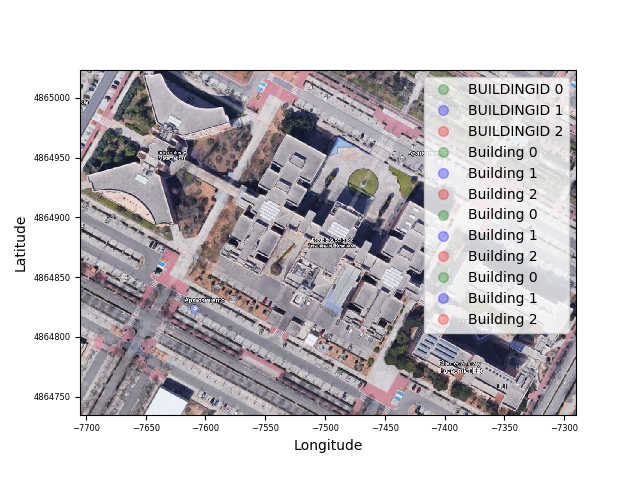

In [5]:
%matplotlib notebook
gbTrain.graphicMap2D(filename="buildingsMap2d", x="LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


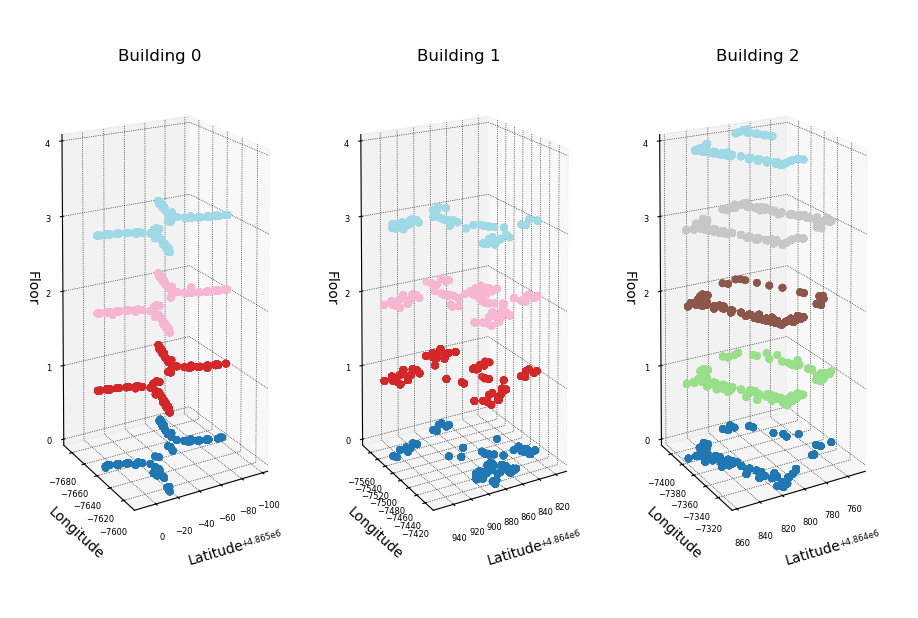

In [5]:
gbTrain.graphicBuildings(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsTrain")

<IPython.core.display.Javascript object>


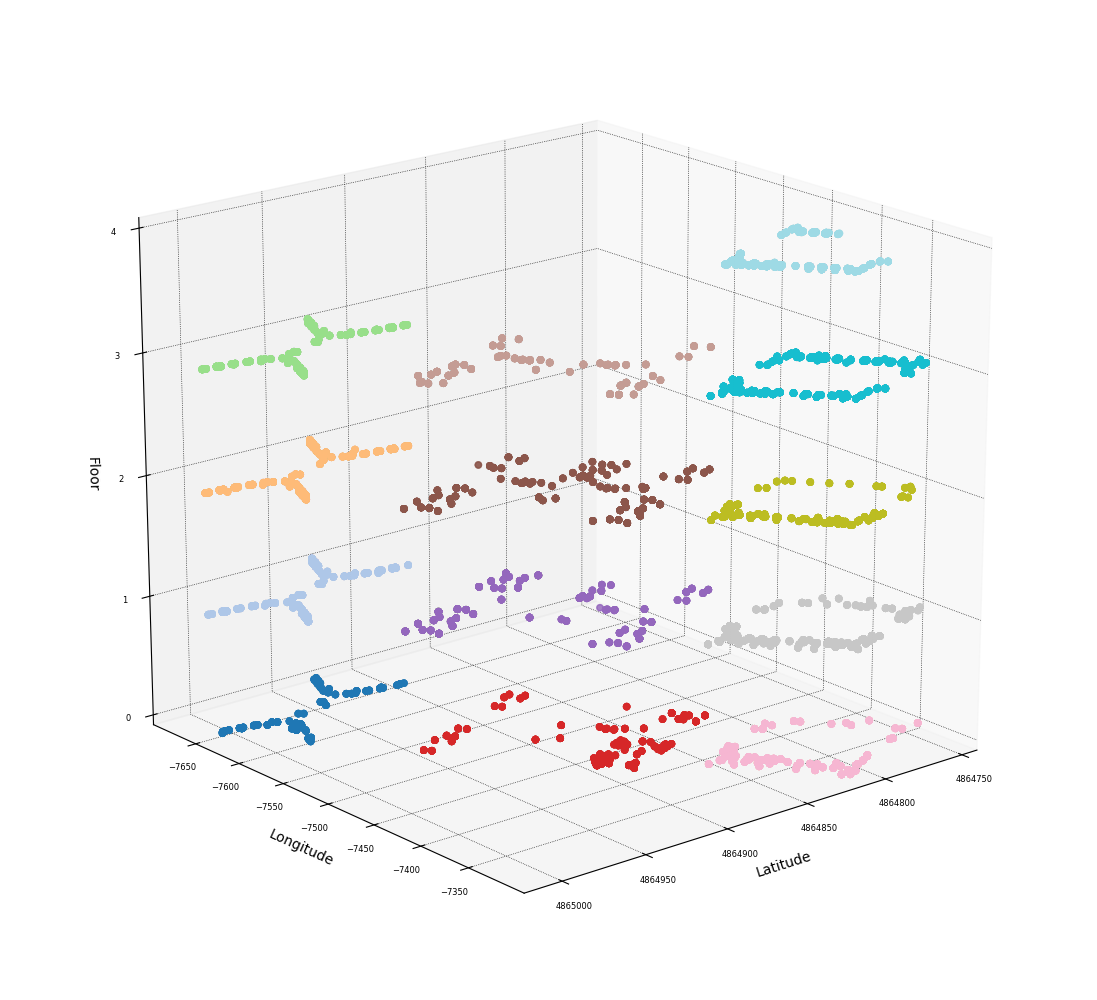

In [6]:
gbTrain.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3d")

## Cleaning the Data

In [7]:
dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
display('Initial Size')
display(dfTrain.shape)

def cleanBySignificance(inputData):
    wifiSens = 520
    noDetectedValue = 100
    wifiColumns = inputData.columns.values[0:wifiSens]
    outColumns = inputData.columns.values[wifiSens:]
    dfTemp = inputData[wifiColumns]

    # drop columns (all rows in a column = 100, dont make any significance)
    wa_columns = pd.DataFrame(dfTemp.sum(axis=0) == inputData.shape[0] * noDetectedValue, columns=['isOut'])
    wa_columns = wa_columns[wa_columns.isOut == False].T.columns.values
    new_columns = list(wa_columns) + list(outColumns)
    inputData = inputData[new_columns]

    # drop rows (all columns = 100 with different spaceId, buildingId, floorId)
    inputData = inputData[dfTemp.sum(axis=1)  != wifiSens * noDetectedValue]
    return inputData, new_columns

dfTrain, columnFilter = cleanBySignificance(dfTrain)
display('New Size')
display(dfTrain.shape)

'Initial Size'

(19937, 529)

'New Size'

(19861, 474)

In [7]:
display(np.min(dfTrain.LONGITUDE))
display(np.max(dfTrain.LONGITUDE))
display(np.min(dfTrain.LATITUDE))
display(np.max(dfTrain.LATITUDE))

-7691.338399998844

-7300.818990092725

4864745.745015971

4865016.687799999

In [ ]:
ARRIBA,LATITUDE: 39.993645 = 4865016.687799999
ABAJO,LATITUDE: 39.991699 = 4864745.745015971
DERECHA,LONGITUDE: -7300.818990092725 = -0.0655337645868923
IZQUIERDA,LONGITUDE: -7691.338399998844 = -0.06913720792978406

min		-7691.338400	4.864746e+06
max		-7300.818990	4.865017e+06

BAJO
39.991699,-0.06595830609238895

ARRIBA
39.993645,-0.06866808995715656

DERECHO
39.992287,-0.0655337645868923

IZQUIERDA
39.993028,-0.06913720792978406

In [ ]:
dfTemp = dfTrain[['LONGITUDE', 'LATITUDE']]
dfTemp['minLong'] = np.min(dfTrain.LONGITUDE)
dfTemp['meanLong'] = np.mean(dfTrain.LONGITUDE)
dfTemp['minLat'] = np.min(dfTrain.LATITUDE)
dfTemp['meanLat'] = np.mean(dfTrain.LATITUDE)
import geopy.distance
dfTrain['LONGITUDE_M'] = geopy.distance.vincenty((dfTemp.meanLat, dfTemp.LONGITUDE), (dfTemp.meanLat, dfTemp.minLong)).m
dfTrain['LATITUDE_M'] = geopy.distance.vincenty((dfTemp.LATITUDE, dfTemp.meanLong), (dfTemp.minLat, dfTemp.meanLong)).m

# lsd = (dfTemp.LATITUDE, dfTemp.LONGITUDE)
#geopy.distance.vincenty((x.meanLat, x.LONGITUDE), (x.meanLat, x.minLong)).m
lsd = dfTemp.apply(lambda x: ((x.meanLat, x.LONGITUDE), (x.meanLat, x.minLong)), axis=1)
lsd

#dfTemp['LONGITUDE'] + dfTemp['LATITUDE']
#-7480.124099999665
geopy.distance.vincenty((4.864746e6, -7536.6211999990055), (4.864746e6, -7300.8189909990055))

4864870.934704428/(39.9929396083499)#60*60*1000)
121643.24459132078/(90*3600)

In [20]:
# import libraries
import folium
import pandas as pd
 
# Make a data frame with dots to show on the map
data = pd.DataFrame({
'lat':[-0.06595830609238895, -0.06866808995715656, -0.0655337645868923, -0.06913720792978406],
'lon':[39.991699, 39.993645, 39.992287, 39.993028],
'name':['Bot', 'Top', 'Right', 'Left']
})
#data
 
# Make an empty map
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=18)
 
# I can add marker one by one on the map
for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name']).add_to(m)

# Save it as html
m.save('images/312_markers_on_folium_map1.html')

In [19]:
# import gmplot package 
import gmplot 
  
#latitude_list = [39.991699, 39.992287, 39.993645, 39.993028]
#longitude_list = [-0.06595830609238895, -0.0655337645868923, -0.06866808995715656, -0.06913720792978406]

latitude_list = [39.991699, 39.991699, 39.993645, 39.993645]
longitude_list = [-0.06913720792978406, -0.0655337645868923, -0.0655337645868923, -0.06913720792978406] #derecha-izquierda#
#izq der der izq
  
gmap5 = gmplot.GoogleMapPlotter(39.9924346,-0.0667435, 18.5) 
  
gmap5.scatter( latitude_list, longitude_list, '# FF0000', size = 5, marker = False) 
  
# polygon method Draw a polygon with 
# the help of coordinates 
gmap5.polygon(latitude_list, longitude_list, color = 'cornflowerblue') 
  
gmap5.draw( "images/312_markers_on_folium_map1.html")

In [21]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

map = Basemap(projection='cyl', 
              lat_0=0, lon_0=0)

map.drawmapboundary(fill_color='#7777ff')
map.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map.drawcoastlines()

lons = np.array([-13.7, -10.8, -13.2, -96.8, -7.99, 7.5, -17.3, -3.7])
lats = np.array([9.6, 6.3, 8.5, 32.7, 12.5, 8.9, 14.7, 40.39])
cases = np.array([1971, 7069, 6073, 4, 6, 20, 1, 1])
deaths = np.array([1192, 2964, 1250, 1, 5, 8, 0, 0])
places = np.array(['Guinea', 'Liberia', 'Sierra Leone','United States', 'Mali', 'Nigeria', 'Senegal', 'Spain'])

x, y = map(lons, lats)

map.scatter(x, y, s=cases, c='r', alpha=0.5)

axins = zoomed_inset_axes(ax, 7, loc=1)
axins.set_xlim(-20, 0)
axins.set_ylim(3, 18)

plt.xticks(visible=False)
plt.yticks(visible=False)

map2 = Basemap(llcrnrlon=-20,llcrnrlat=3,urcrnrlon=0,urcrnrlat=18, ax=axins)
map2.drawmapboundary(fill_color='#7777ff')
map2.fillcontinents(color='#ddaa66', lake_color='#7777ff', zorder=0)
map2.drawcoastlines()
map2.drawcountries()

map2.scatter(x, y, s=cases/5., c='r', alpha=0.5)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

<IPython.core.display.Javascript object>


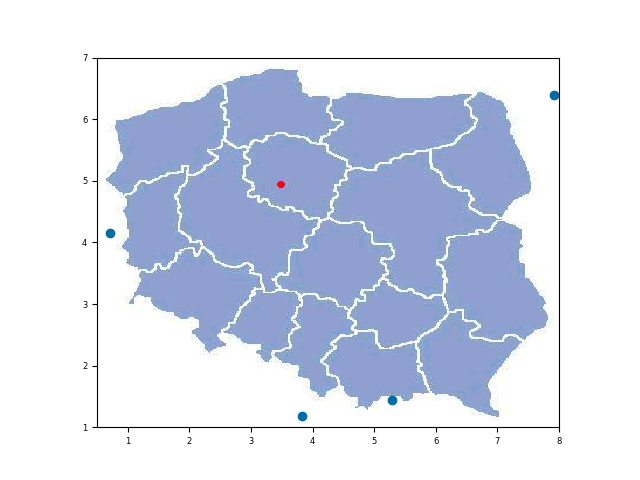

In [79]:
np.random.seed(0)
x = np.random.uniform(0.0,10.0,15)
y = np.random.uniform(0.0,10.0,15)
#import matplotlib.cbook as cbook
#datafile = cbook.get_sample_data('images/mapa.jpg')
img = imread("images/mapa.jpg")
#img = imread(datafile)
plt.scatter(x,y,zorder=1)
plt.imshow(img, zorder=0, extent=[0.5, 8.0, 1.0, 7.0])
plt.show()

<IPython.core.display.Javascript object>


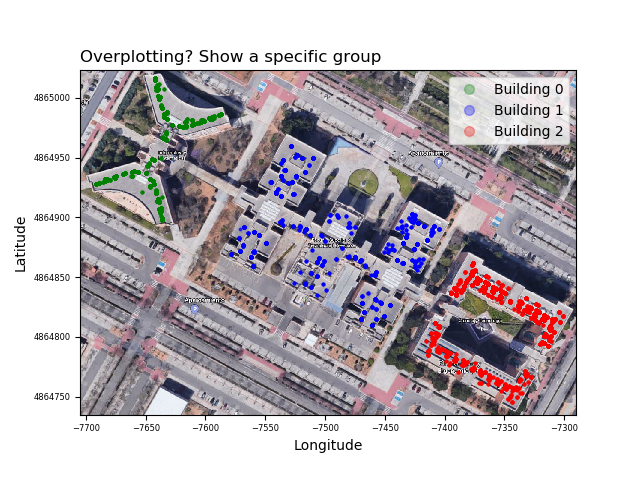

In [13]:
from scipy.misc import imread

#hax = sns.lmplot(x="LATITUDE", y="LONGITUDE", hue="BUILDINGID", data=dfTrain, fit_reg=False, markers='.') # x_jitter=.5, , y_jitter=.1, 
#plt.plot( 'LONGITUDE', 'LATITUDE', data=dfTrain, linestyle='', marker='o', markersize=1.5, color="grey", alpha=0.3, label='other group', zorder=1)
plt.plot( 'LONGITUDE', 'LATITUDE', data=dfTrain[dfTrain.BUILDINGID=='0'], linestyle='', marker='.', markersize=3.5, alpha=0.3, label='Building 0', zorder=2, color='g')
plt.plot( 'LONGITUDE', 'LATITUDE', data=dfTrain[dfTrain.BUILDINGID=='1'], linestyle='', marker='.', markersize=3.5, alpha=0.3, label='Building 1', zorder=2, color='b')
plt.plot( 'LONGITUDE', 'LATITUDE', data=dfTrain[dfTrain.BUILDINGID=='2'], linestyle='', marker='.', markersize=3.5, alpha=0.3, label='Building 2', zorder=2, color='r')
#ax1 = plt.imshow(im, zorder=1)
#ax1.zorder = 1
plt.legend(markerscale=4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Overplotting? Show a specific group', loc='left')
img = imread("images/geomap2d.jpg")
#plt.imshow(img,zorder=0, extent=[-7691.338399998844, -7300.818990092725, 4864745.745015971, 4865016.687799999])
plt.imshow(img,zorder=0, extent=[-7705, -7290, 4864735, 4865023])
#ARRIBA,LATITUDE: 39.993645 = 4865016.687799999
#ABAJO,LATITUDE: 39.991699 = 4864745.745015971
#DERECHA,LONGITUDE: -7300.818990092725 = -0.0655337645868923
#IZQUIERDA,LONGITUDE: -7691.338399998844 = -0.06913720792978406
plt.show()
#plt.savefig("images/"+str(filename)+".svg")

## Mixed Prediction

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

seed = 7
wifiSens = 520
xTrain = dfTrain[dfTrain.columns.values[0:wifiSens]]
# xTrain = dfTrain #[list(wa_columns)]
xTest = dfTest[dfTest.columns.values[0:wifiSens]]
#xTest = dfTest #[list(wa_columns)]

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.FLOOR)
p_floor = model.predict(xTest)
display('Floor Classification Score')
display(model.score(xTest, dfTest.FLOOR))

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.BUILDINGID)
p_building = model.predict(xTest)
display('Building Classification Score')
display(model.score(xTest, dfTest.BUILDINGID))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LATITUDE)
p_latitude = model.predict(xTest)
display('Latitude Regression Score')
display(model.score(xTest, dfTest.LATITUDE))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LONGITUDE)
p_longitude = model.predict(xTest)
display('Longitude Regression Score')
display(model.score(xTest, dfTest.LONGITUDE))

# setting predicted values into dataframe
dfTest['PRED_FLOOR'] = p_floor
dfTest['PRED_BUILDING'] = p_building
dfTest['PRED_LATITUDE'] = p_latitude
dfTest['PRED_LONGITUDE'] = p_longitude

'Floor Classification Score'

0.8046804680468047

'Building Classification Score'

0.9981998199819982

'Latitude Regression Score'

0.9626092899099439

'Longitude Regression Score'

0.9833886078390593

<IPython.core.display.Javascript object>


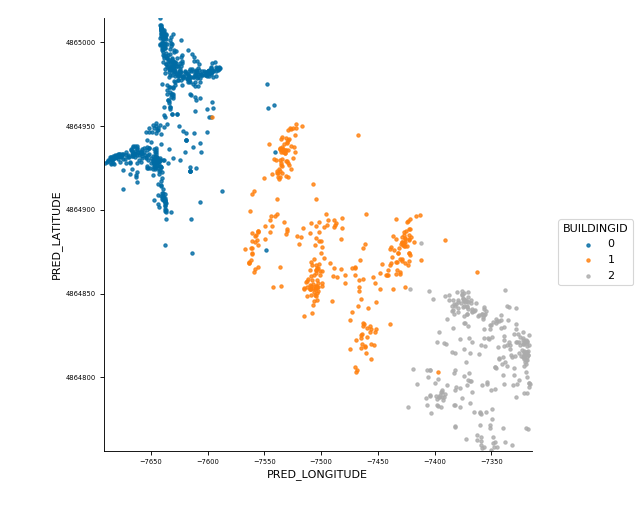

In [17]:
graphicMap2D(dfTest, filename="predicted2d", x = "PRED_LONGITUDE", y="PRED_LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


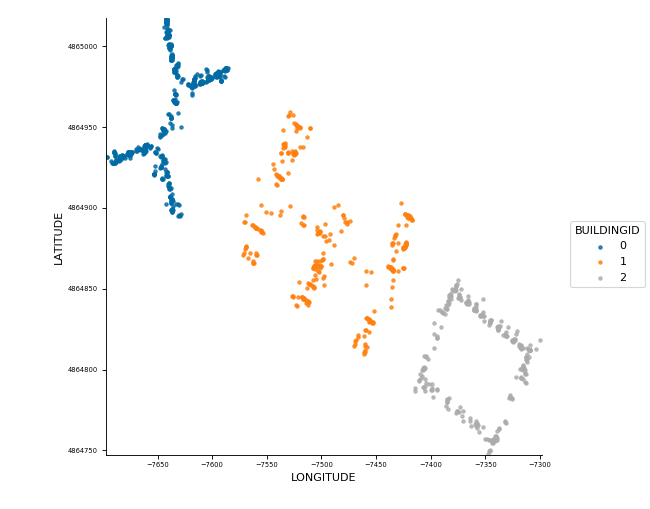

In [16]:
graphicMap2D(dfTest, filename="validated2d", x = "LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


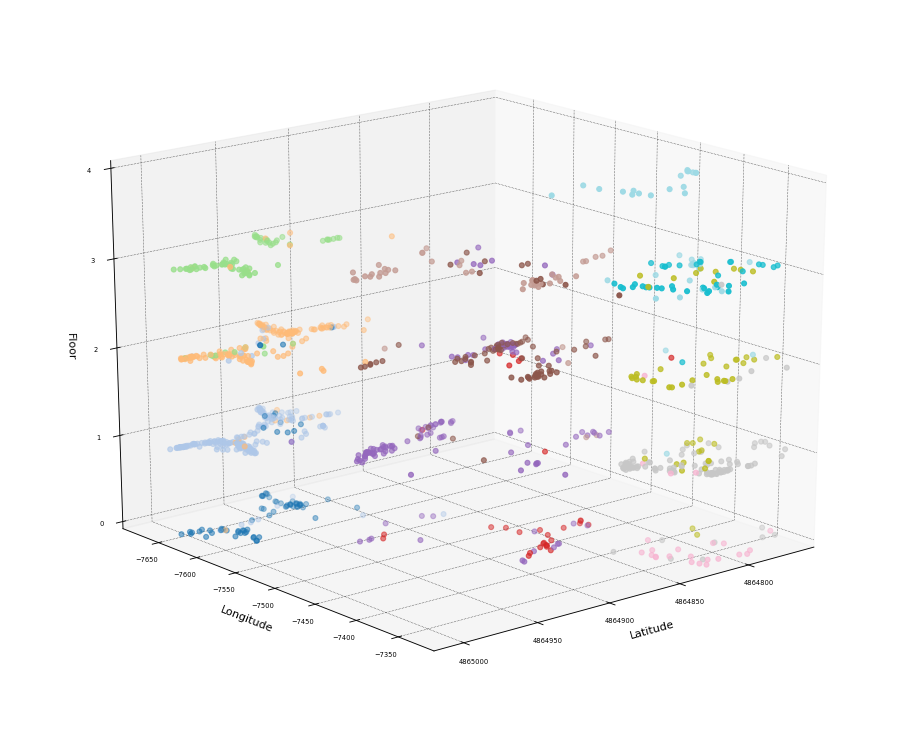

In [18]:
graphicMap3D(dfTest, columns = ["PRED_LATITUDE", "PRED_LONGITUDE", "PRED_FLOOR"], filename="predictedBuildingsMap3d")

<IPython.core.display.Javascript object>


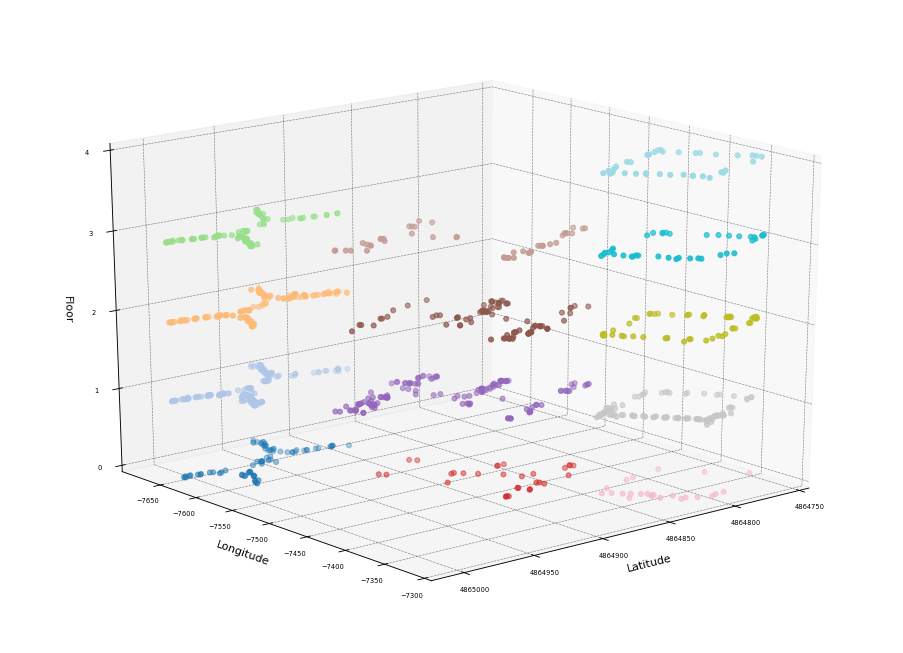

In [19]:
graphicMap3D(dfTest, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="realBuildingsMap3d")